# Vehicle MOT History Analysis

This Jupyter notebook retrieves and analyses MOT (Ministry of Transport) test history for a specified vehicle using the DVSA (Driver and Vehicle Standards Agency) MOT History API. It produces a two-part visualisation:
- A mileage plot showing the vehicle's odometer readings over time.
- A fault plot displaying the number and severity of faults recorded during MOT tests.

## Dependencies
- `plotnine`: For creating visualisations using a grammar of graphics approach.
- `mizani`: For customising plot scales and breaks.
- `requests`: For making HTTP requests to the DVSA API.
- `pandas`: For data manipulation and analysis.
- `json`: For inspecting API responses.
- `os`: For handling file paths.
- `datetime`: For parsing dates in MOT data.
- `numpy`: For conditional operations (e.g., converting odometer units).

## Notes
- To run this code, you can either obtain an API key (https://documentation.history.mot.api.gov.uk/) and visualise data for vehicles of your choice, or use one of the five example JSON files in the `data` directory of the project repository. Run **either Cell 2 (to use your own API key and vehicle)** or **Cell 3 (example JSON)** to load `mot_data`, not both.
- This code only works for vehicles that have undertaken at least one MOT test, which means that they must be at least 3 years old (vehicles are not required to be tested for the first 3 years after registration).
- The code handles cases where data may be missing or empty, and adapts the visualisations to respond to each vehicle.
- Visualisations are styled to be consistent with the UK GOV website.

In [1]:
import requests
import pandas as pd
import json
import os
import numpy as np
from datetime import datetime
from plotnine import *
from mizani.breaks import breaks_extended

In [ ]:
# Vehicle registration (input registration number for the vehicle of interest)
VEHICLE_REGISTRATION = "YOUR_REGISTRATION"

# Define API credentials and endpoints (obtain from https://documentation.history.mot.api.gov.uk/)
CLIENT_ID = "YOUR_CLIENT_ID"
CLIENT_SECRET = "YOUR_CLIENT_SECRET"
API_KEY = "YOUR_API_KEY"
TOKEN_URL = "https://..."
SCOPE = "https://..."
MOT_API_URL = f"https://...{VEHICLE_REGISTRATION}"

def get_access_token():
    """Retrieve an OAuth2 access token from the DVSA API."""
    response = requests.post(
        TOKEN_URL,
        data={
            "grant_type": "client_credentials",
            "client_id": CLIENT_ID,
            "client_secret": CLIENT_SECRET,
            "scope": SCOPE
        },
        headers={"Content-Type": "application/x-www-form-urlencoded"}
    )
    response.raise_for_status()
    return response.json()["access_token"]

def get_mot_history(token):
    """Fetch MOT history data for the specified vehicle using the provided access token."""
    headers = {
        "Authorization": f"Bearer {token}",
        "X-API-Key": API_KEY
    }
    response = requests.get(MOT_API_URL, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"MOT history request failed: {response.status_code} - {response.text}")

# Fetch MOT data
access_token = get_access_token()
mot_data = get_mot_history(access_token)

# Print MOT data for inspection
print(json.dumps(mot_data, indent=2))

In [2]:
# Start here if you don’t have an API key
# Enter the name of a JSON file (e.g., MW02WVU.json) in the 'data' directory
print("Start here if you don’t have an API key.")
print("Enter the name of one of the example JSON files (MW02WVU.json, SK05HZC.json, YE55XSR.json, OY15CGK.json, MF68CZR.json):")
filename = input()

# Load JSON file into mot_data
file_path = os.path.join("data", filename)
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File '{file_path}' not found. Ensure it exists in the 'data' directory.")
with open(file_path, "r") as f:
    mot_data = json.load(f)

# Print MOT data for inspection
print(json.dumps(mot_data, indent=2))

Start here if you don’t have an API key.
Enter the name of one of the example JSON files (MW02WVU.json, SK05HZC.json, YE55XSR.json, OY15CGK.json, MF68CZR.json):


 MW02WVU.json


{
  "registration": "MW02WVU",
  "make": "AUDI",
  "model": "A2",
  "firstUsedDate": "2002-06-19",
  "fuelType": "Petrol",
  "primaryColour": "Blue",
  "registrationDate": "2002-06-19",
  "manufactureDate": "2002-06-19",
  "engineSize": "1390",
  "hasOutstandingRecall": "Unknown",
  "motTests": [
    {
      "registrationAtTimeOfTest": null,
      "motTestNumber": "926036620138",
      "completedDate": "2025-08-18T14:06:37.000Z",
      "expiryDate": "2026-09-06",
      "odometerValue": "85703",
      "odometerUnit": "MI",
      "odometerResultType": "READ",
      "testResult": "PASSED",
      "dataSource": "DVSA",
      "defects": [
        {
          "dangerous": false,
          "text": "Oil leak, but not excessive (8.4.1 (a) (i))",
          "type": "ADVISORY"
        },
        {
          "dangerous": false,
          "text": "Nearside Rear Inner Tyre slightly damaged/cracking or perishing (5.2.3 (d) (ii))",
          "type": "ADVISORY"
        },
        {
          "dangerous":

## Data Extraction and Processing

This cell processes the MOT history data (`mot_data`) into a structured DataFrame:
- Extracts vehicle details (registration, make, model, colour, etc.).
- Flattens nested MOT test data and defects into a DataFrame.
- Adds a registration date row with zero odometer reading.
- Converts dates to a consistent format, handling multiple possible formats.
- Converts odometer readings to miles (if in kilometres). Note: sometimes MOT testers report vehicle mileage in kilometers but record the units in miles - this code does not account for these mistakes.
- Assigns MOT test results (`Pass`/`Fail`) and fault types (`Advisory`, `Minor`, `Major`, `Dangerous`). Advisory faults should be monitored and repaired if necessary, Minor faults should be monitored and repaired as soon as possible, Major faults should be repaired before driving again (unless to a garage), Dangerous faults should be repaired immediately (illegal to drive until fixed).
- Produces a `result` DataFrame with columns: `registration`, `make`, `model`, `colour`, `date_time`, `odometer_mi`, `mot_test`, `fault_type`, `fault_text`, `motTestNumber`.

In [3]:
# Extract top-level vehicle info, handling missing data
dat = mot_data[0] if isinstance(mot_data, list) else mot_data
registration = dat.get("registration", pd.NA)
make = dat.get("make", pd.NA)
model = dat.get("model", pd.NA)
primary_colour = dat.get("primaryColour", pd.NA)
first_used_date = dat.get("firstUsedDate", pd.NA)
registration_date = dat.get("registrationDate", pd.NA)

# Extract MOT test data
mot_tests = dat.get("motTests", [])
mot_df = pd.DataFrame([
    {
        "motTestNumber": test.get("motTestNumber", pd.NA),
        "completedDate": test.get("completedDate", pd.NA),
        "expiryDate": test.get("expiryDate", pd.NA),
        "odometerValue": test.get("odometerValue", pd.NA),
        "odometerUnit": test.get("odometerUnit", pd.NA),
        "odometerResultType": test.get("odometerResultType", pd.NA),
        "testResult": test.get("testResult", pd.NA),
        "dataSource": test.get("dataSource", pd.NA),
        "defects": test.get("defects", [])
    }
    for test in mot_tests
])

# Add vehicle info to MOT DataFrame
mot_df["registration"] = registration
mot_df["make"] = make
mot_df["model"] = model
mot_df["colour"] = primary_colour
mot_df["odometerValue"] = pd.to_numeric(mot_df["odometerValue"], errors="coerce")

# Unnest defects
mot_df = mot_df.explode("defects").reset_index(drop=True)
mot_df["dangerous"] = mot_df["defects"].apply(
    lambda x: x.get("dangerous", pd.NA) if isinstance(x, dict) else pd.NA
)
mot_df["text"] = mot_df["defects"].apply(
    lambda x: x.get("text", pd.NA) if isinstance(x, dict) else pd.NA
)
mot_df["type"] = mot_df["defects"].apply(
    lambda x: x.get("type", pd.NA) if isinstance(x, dict) else pd.NA
)
mot_df = mot_df.drop(columns=["defects"])

# Create registration row
reg_date = first_used_date if pd.notna(first_used_date) else registration_date
reg_row = pd.DataFrame({
    "motTestNumber": [pd.NA],
    "completedDate": [reg_date],
    "odometerValue": [0],
    "odometerUnit": ["MI"],
    "testResult": [pd.NA],
    "registration": [registration],
    "make": [make],
    "model": [model],
    "colour": [primary_colour],
    "dangerous": [pd.NA],
    "text": [pd.NA],
    "type": [pd.NA]
})

# Combine registration row with MOT data
result = pd.concat([reg_row, mot_df], ignore_index=True)

# Process dates with multiple format attempts
def parse_date(date_str):
    if pd.isna(date_str):
        return pd.NA
    date_str = date_str.replace("Z", "")
    formats = [
        "%Y-%m-%d",
        "%Y-%m-%dT%H:%M:%S.%f",
        "%Y-%m-%d %H:%M:%S",
        "%Y-%m-%dT%H:%M:%S",
        "%Y-%m-%d %H:%M"
    ]
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt, errors="raise")
        except (ValueError, TypeError):
            continue
    print(f"Failed to parse date: {date_str}")
    return pd.NA

result["date_time"] = result["completedDate"].apply(parse_date)
result["odometer_mi"] = np.where(
    result["odometerUnit"].str.lower() == "km",
    result["odometerValue"] * 0.621371,
    result["odometerValue"]
)

# Assign mot_test with string dtype
result["mot_test"] = result["testResult"].str.lower().map({
    "passed": "Pass",
    "failed": "Fail"
}).astype("string").fillna(pd.NA)

# Assign fault_type
def assign_fault_type(row):
    if pd.isna(row["type"]):
        return pd.NA
    if row["dangerous"] == True:
        return "Dangerous"
    if row["type"] in ["FAIL", "PRS"]:
        return "Major"
    if "advisory" in row["type"].lower() or "user entered" in row["type"].lower():
        return "Advisory"
    if "minor" in row["type"].lower():
        return "Minor"
    if "major" in row["type"].lower():
        return "Major"
    if "dangerous" in row["type"].lower():
        return "Dangerous"
    return "Advisory"

result["fault_type"] = result.apply(assign_fault_type, axis=1).astype("string")
result["fault_text"] = result["text"].astype("string")

# Debug: Print problematic dates
invalid_dates = result[result["date_time"].isna()]["completedDate"].unique()
if len(invalid_dates) > 0:
    print("Invalid date formats found:", invalid_dates)

# Select final columns
result = result[[
    "registration",
    "make",
    "model",
    "colour",
    "date_time",
    "odometer_mi",
    "mot_test",
    "fault_type",
    "fault_text",
    "motTestNumber"
]]

# Print result for inspection
print(result)

   registration  make model colour           date_time  odometer_mi mot_test  \
0       MW02WVU  AUDI    A2   Blue 2002-06-19 00:00:00          0.0     <NA>   
1       MW02WVU  AUDI    A2   Blue 2025-08-18 14:06:37      85703.0     Pass   
2       MW02WVU  AUDI    A2   Blue 2025-08-18 14:06:37      85703.0     Pass   
3       MW02WVU  AUDI    A2   Blue 2025-08-18 14:06:37      85703.0     Pass   
4       MW02WVU  AUDI    A2   Blue 2025-08-18 14:06:37      85703.0     Pass   
..          ...   ...   ...    ...                 ...          ...      ...   
77      MW02WVU  AUDI    A2   Blue 2010-06-08 13:21:30      25454.0     Pass   
78      MW02WVU  AUDI    A2   Blue 2009-06-12 10:51:03      23309.0     Pass   
79      MW02WVU  AUDI    A2   Blue 2008-06-16 12:16:43      21176.0     Pass   
80      MW02WVU  AUDI    A2   Blue 2007-06-15 10:11:12      18549.0     Pass   
81      MW02WVU  AUDI    A2   Blue 2006-06-02 10:07:44      15979.0     Pass   

   fault_type                          

## Data Preparation for Visualisation

This cell prepares the `result` DataFrame for visualisation:
- Defines fault types (`Advisory`, `Minor`, `Major`, `Dangerous`) as a categorical variable for consistent ordering.
- Extracts the year from test dates and converts odometer readings to thousands of miles.
- Selects one MOT test per year, prioritising 'Fail' over 'Pass' tests.
- Summarises faults by year and fault type, ensuring all fault categories are included.
- Prepares data for a tile-based fault visualisation by calculating cumulative fault counts.

In [4]:
# Define fault types as a categorical variable
all_faults = ["Advisory", "Minor", "Major", "Dangerous"]
result["fault_type"] = pd.Categorical(
    result["fault_type"],
    categories=all_faults,
    ordered=True
)

# Extract year and convert odometer to thousands of miles
data = result.copy()
data["year"] = data["date_time"].dt.year
data = data.dropna(subset=["year"])
data["odometer_kmi"] = data["odometer_mi"] / 1000

# Handle empty or invalid year data
if data.empty or data["year"].isna().all():
    print("Warning: No valid years found in the data. Skipping visualisation.")
    all_years = [2010]  # Fallback to registration year
else:
    all_years = range(int(data["year"].min()), int(data["year"].max()) + 1)

# Select one MOT test per year, prioritising Fail over Pass
def select_one_test_per_year(group):
    """Select one MOT test per year, prioritising 'Fail' over 'Pass'."""
    if (group["mot_test"] == "Fail").any():
        fail_test = group[group["mot_test"] == "Fail"].sort_values("date_time").iloc[0]
        return group[group["motTestNumber"] == fail_test["motTestNumber"]]
    if (group["mot_test"] == "Pass").any():
        pass_test = group[group["mot_test"] == "Pass"].sort_values("date_time").iloc[0]
        return group[group["motTestNumber"] == pass_test["motTestNumber"]]
    return group.sort_values("date_time").iloc[0:1]

data_year = data.groupby("year").apply(
    select_one_test_per_year,
    include_groups=False
).reset_index()

# Summarise faults by year and fault type
data_fault_summary = data_year.groupby(
    ["year", "fault_type"],
    observed=False
).size().reset_index(name="fault_count")

# Ensure all fault types are included
data_fault_summary = data_fault_summary.pivot_table(
    index="year",
    columns="fault_type",
    values="fault_count",
    fill_value=0,
    observed=False
).reindex(
    columns=all_faults,
    fill_value=0
).reset_index()

# Melt back to long format
data_fault_summary = data_fault_summary.melt(
    id_vars="year",
    value_vars=all_faults,
    value_name="fault_count",
    var_name="fault_type"
)
data_fault_summary["fault_type"] = pd.Categorical(
    data_fault_summary["fault_type"],
    categories=all_faults,
    ordered=True
)

# Calculate total faults per year
data_fault_total = data_fault_summary.groupby(
    "year",
    observed=False
)["fault_count"].sum().reset_index(name="total")

# Prepare tile positions for fault visualisation
data_fault_tiles = data_fault_summary[data_fault_summary["fault_count"] > 0].copy()
if not data_fault_tiles.empty:
    data_fault_tiles = data_fault_tiles.sort_values(["year", "fault_type"])
    data_fault_tiles["cum_fault_count"] = data_fault_tiles.groupby(
        "year",
        observed=False
    )["fault_count"].cumsum().shift(fill_value=0)
    data_fault_tiles = data_fault_tiles.loc[
        data_fault_tiles.index.repeat(data_fault_tiles["fault_count"])
    ].reset_index(drop=True)
    data_fault_tiles["tile_id"] = data_fault_tiles.groupby(
        "year",
        observed=False
    ).cumcount() + 1
    data_fault_tiles["y_position"] = data_fault_tiles["tile_id"] - 0.5
    data_fault_tiles["fault_type"] = pd.Categorical(
        data_fault_tiles["fault_type"],
        categories=all_faults,
        ordered=True
    )
else:
    print("Warning: No faults found in the data. Skipping fault visualisation.")
    data_fault_tiles = pd.DataFrame(
        columns=["year", "fault_type", "fault_count", "cum_fault_count", "tile_id", "y_position"]
    )

## Visualisation: Mileage Plot

This cell creates a plot with a dynamic title showing the vehicle's odometer readings (in thousands of miles) over time. The plot uses area, a line, and points to highlight annual MOT test results. Certain elements are removed (x axis text) since this plot makes up the top panel of the final visualisation. Element positioning is optimised for the final visualisation PNG output.

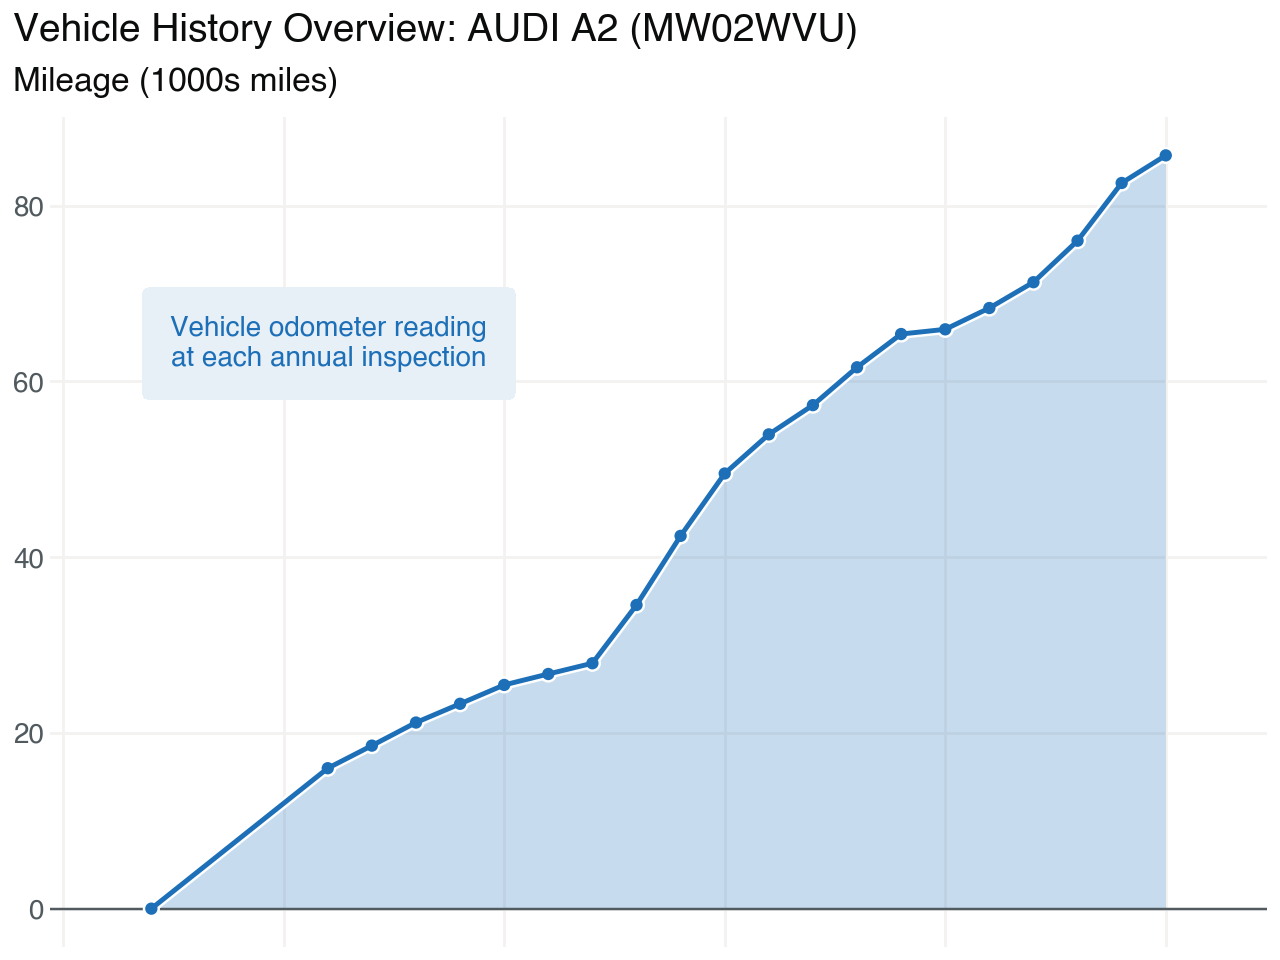

In [5]:
# Prepare mileage data
mileage_data = data.groupby('year')['odometer_kmi'].max().reset_index()
mileage_data = mileage_data[mileage_data['odometer_kmi'].notna()]

# Define plot parameters to respond to vehicle data
x_limits = [min(data['year'].dropna()) - 1, max(data['year'].dropna()) + 1]
x_breaks = breaks_extended()(x_limits)
x_range = max(data['year'].dropna()) - min(data['year'].dropna())
y_limits_mileage = [0, max(data['odometer_kmi'].dropna(), default=1)]
y_breaks_mileage = breaks_extended()(y_limits_mileage)

# Define colours (UK GOV)
white = '#ffffff'
black = '#0b0c0c'
grey = '#505a5f'
lightgrey = '#f3f2f1'
blue = '#1d70b8'
lightblue = "#e7f0f7"

# Create mileage plot with plotnine
plot_mileage = (
    ggplot(
        mileage_data,
        aes(x = 'year', y = 'odometer_kmi')
    ) +
    # Data layers
    geom_area(
        fill = blue,
        alpha = 0.25
    ) +
    geom_hline(
        yintercept = 0,
        color = grey
    ) +
    geom_line(
        color = white,
        size = 2
    ) +
    geom_point(
        color = white,
        size = 2.5
    ) +
    geom_line(
        color = blue,
        size = 1
    ) +
    geom_point(
        color = blue,
        size = 1.5
    ) +
    # Label
    geom_label(
        x = min(data['year'].dropna()) + (x_range * 0.175),
        y = (y_limits_mileage[1]) * 0.75,
        label = "Vehicle odometer reading\nat each annual inspection",
        size = 10,
        color = blue,
        fill = lightblue,
        label_size = 0,
        ha = 'center',
        va = 'center',
        label_padding = 1
    ) +
    # Scales
    scale_x_continuous(
        limits = x_limits,
        breaks = x_breaks,
        expand = [0.05, 0.05]
    ) +
    scale_y_continuous(
        limits = y_limits_mileage,
        breaks = y_breaks_mileage,
        expand = [0.05, 0.1]
    ) +
    # Labels
    labs(
        title = f"Vehicle History Overview: {make} {model} ({registration})",
        subtitle='Mileage (1000s miles)'
    ) +
    # Themes
    theme_minimal() +
    theme(
        # Gridlines
        panel_grid_minor = element_blank(),
        panel_grid_major = element_line(color = lightgrey),
        # Text
        plot_title_position = 'plot',
        plot_title = element_text(
            size = 14,
            weight = 'bold',
            color = black,
            ha = 'left',
            margin = {'b': 5}
        ),
        plot_subtitle = element_text(
            size = 12,
            #weight = 'bold',
            color = black,
            ha = 'left',
            margin = {'b': 5}
        ),
        axis_text_y = element_text(size = 10, color = grey),  
        axis_text_x = element_blank(),
        axis_title = element_blank() 
    )
)

# Inspect plot
plot_mileage

## Visualisation: Fault Plot

This cell creates a tile plot showing the number and severity of faults recorded during MOT tests. Each tile represents a fault, coloured by severity (Advisory, Minor, Major, Dangerous). Element positioning is optimised for the final visualisation PNG output.

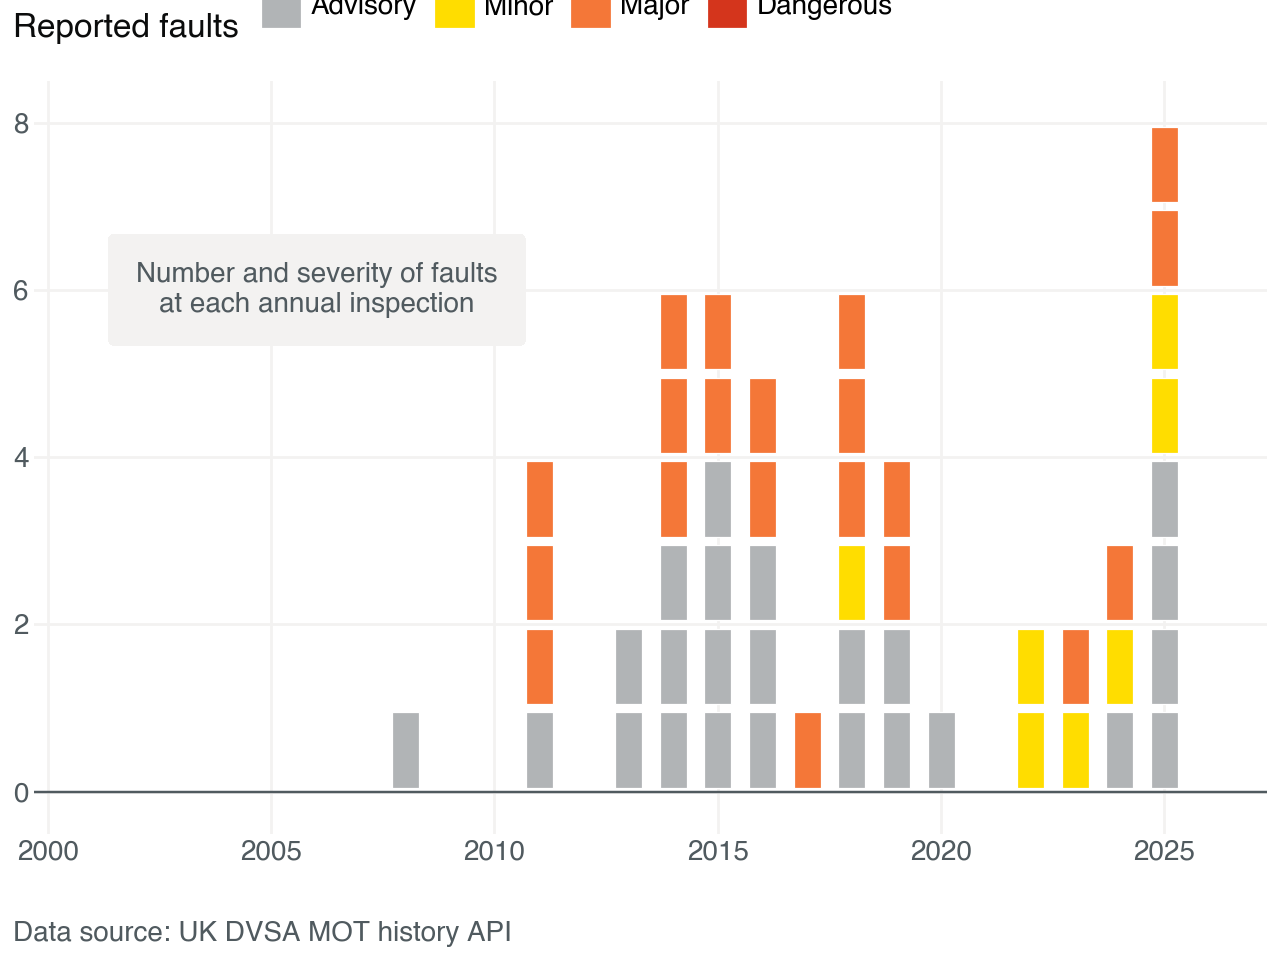

In [6]:
# Ensure consistent fault type ordering
all_faults = ['Advisory', 'Minor', 'Major', 'Dangerous']
data_fault_tiles['fault_type'] = pd.Categorical(data_fault_tiles['fault_type'], categories=all_faults, ordered=True)
legend_data = pd.DataFrame({
    'fault_type': pd.Categorical(all_faults, categories=all_faults, ordered=True),
    'year': min(data['year']) - 0.5,
    'y_position': max(data_fault_total['total']) + 1
})

# Define plot parameters to respond to vehicle data
x_limits = [min(data['year'].dropna()) - 1, max(data['year'].dropna()) + 1]
x_breaks = breaks_extended()(x_limits)
x_range = max(data['year'].dropna()) - min(data['year'].dropna())
y_limits_fault = [0, max(data_fault_total['total'].dropna(), default=1)]
y_breaks_fault = breaks_extended(n=4, Q=[1, 2, 5, 10])(y_limits_fault)

# Define colours (UK GOV)
white = '#ffffff'
black = '#0b0c0c'
grey = '#505a5f'
mediumgrey = '#b1b4b6'
lightgrey = '#f3f2f1'
red = '#d4351c'
orange = '#f47738'
yellow = '#ffdd00'

# Create fault plot
plot_fault = (
    ggplot(
        data_fault_tiles,
        aes(x = 'year', y = 'y_position', fill = 'fault_type')
    ) +
    # Data layers
    geom_tile(
        height = 0.9,
        width = 0.6,
        color = white,
        size = 0.25
    ) +
    # Zero baseline
    geom_hline(yintercept = 0, color = grey)
    # Label
    + geom_label(
        x = min(data['year'].dropna()) + (x_range * 0.175),
        y = (y_limits_fault[1]) * 0.75,
        label = "Number and severity of faults\nat each annual inspection",
        size = 10,
        color = grey,
        fill = lightgrey,
        label_size = 0,
        ha = 'center',
        va = 'center',
        label_padding = 1
    ) +
    # Scales
    scale_x_continuous(
        limits = x_limits,
        breaks = x_breaks,
        expand = [0.05, 0.05]
    ) +
    scale_y_continuous(
        limits = y_limits_fault,
        breaks = y_breaks_fault,
        expand = [0.05, 0.1]
    ) +
    scale_fill_manual(
        values={
            'Dangerous': red,
            'Major': orange,
            'Minor': yellow,
            'Advisory': mediumgrey
        },
        breaks = all_faults,
        limits = all_faults,
        drop = False
    ) +
    # Labels
    labs(
        subtitle = 'Reported faults',
        x = 'Year',
        caption = 'Data source: UK DVSA MOT history API'
    ) +
    # Themes
    theme_minimal() +
    theme(
        # Gridlines
        panel_grid_minor = element_blank(),
        panel_grid_major = element_line(color = lightgrey),
        #Text
        plot_title_position = 'plot',
        plot_subtitle = element_text(
            size = 12,
            #weight = 'bold',
            color = black,
            ha = 'left',
            margin = {'b': 10},
            hjust = 0
        ),
        plot_caption_position = 'plot',
        plot_caption = element_text(
            size = 10,
            color = grey,
            ha = 'left',
            margin = {'t': 15}),
        axis_text = element_text(size = 10, color = grey),
        axis_title_y = element_blank(),
        axis_title_x = element_blank(),
        legend_text = element_text(size = 10),
        legend_title = element_blank(),
        # Legend
        legend_position = (0.375, 1.1375),
        legend_key_size = 15,
        legend_direction = 'horizontal'
    )
    + guides(fill=guide_legend(nrow=1, override_aes={'alpha': 1}))
)

# Inspect plot
plot_fault

## Combined Visualisation and Output

This cell combines the mileage and fault plots vertically into a single visualisation and saves it as a high-resolution PNG file in the 'outputs' directory.

In [7]:
# Create outputs directory if it doesn't exist
os.makedirs("outputs", exist_ok = True)

# Stack the plots vertically with appropriate margins
plot_combined = (
    plot_mileage + theme(
        plot_margin_top = 0.035,
        plot_margin_right = 0.05,
        plot_margin_bottom = 0.005,
        plot_margin_left = 0.05
    )
) / (
    plot_fault + theme(
        plot_margin_top = 0.005,
        plot_margin_right = 0.05,
        plot_margin_bottom = 0.035,
        plot_margin_left = 0.05
    )
)

# Add figure size and DPI settings
plot_combined = plot_combined + theme(
    figure_size = (7.5, 7.5),
    dpi = 600,
)

# Save plot
output_path = os.path.join('outputs', f"{registration}.png")
plot_combined.save(
    output_path,
    width = 12,
    height = 8,
    dpi = 600,
    backend = 'agg'
)

# Inspect plot
plot_combined